# This code is a simple introduction to Cpx-Liquid melt matching
- for a more advanced example, see Cpx_MeltMatch2_ScruggsPutirka
- The data is from Gleeson et al. (2020) - JPET - https://doi.org/10.1093/petrology/egaa094

## This imports all the python things you need

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("../../..") # This allows you to put the python file in the folder above. So you can have lots of sub folders
import matplotlib.pyplot as plt
import Thermobar as pt
import sympy as sym

## This sets plotting parameters

In [2]:
# This sets some plotting things
plt.rcParams["font.family"] = 'arial'
plt.rcParams["font.size"] =12
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1 
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 4 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 14 # Overall title
plt.rcParams["axes.labelsize"] = 14 # Axes labels



C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Loading in Data

- In this case, Gleson et al had cpxs in the sheet "cpxs" and melts in the "melts"
- You column headings need to be "Sample_ID", "SiO2_Liq", "MgO_Cpx" etc. e.g., oxide, then underscore, capital letter for phase

In [3]:
# Loading Liquids
out=pt.import_Excel('Gleeson2020JPET_Input_Pyroxene_Melts.xlsx', sheet_name="Melts")
my_input_Liqs=out['my_input']
myLiquids1=out['Liqs']

out2=pt.import_Excel('Gleeson2020JPET_Input_Pyroxene_Melts.xlsx', sheet_name="Cpxs")
my_input_Cpxs=out2['my_input']
myCPXs1=out2['Cpxs']


# This loads in published barometry from Gleeson et al. You can delete this from your system, or swap it for something else useful. 
Published=pd.read_excel('Gleeson2020JPET_Input_Pyroxene_Melts.xlsx', sheet_name="NP_Out")


We have set Fe3Fet_Liq to zero, as you only entered FeOt. You can input a Fe3FeT_Liq column to specify this value instead


In [4]:
# You can check inputs have read in right using .head()
display(myLiquids1.head())
display(myCPXs1.head())

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,H2O_Liq,Fe3FeT_Liq,NiO_Liq,CoO_Liq,CO2_Liq,Sample_ID_Liq
0,47.1519,1.7168,15.5321,9.7208,0.1888,5.939515,12.3617,3.7556,1.1877,0.0,0.2766,0.0,0,0.0,0.0,0.0,0
1,46.7277,1.7708,15.4931,9.5435,0.2096,6.098350,12.3699,3.7058,1.2644,0.0,0.1887,0.0,0,0.0,0.0,0.0,1
2,47.5265,1.8483,15.7152,9.6930,0.1678,6.184563,12.3625,3.5107,1.2066,0.0,0.2055,0.0,0,0.0,0.0,0.0,2
3,47.2916,1.7307,15.5250,9.3999,0.1588,6.322718,12.3696,3.9281,1.2285,0.0,0.2406,0.0,0,0.0,0.0,0.0,3
4,47.2260,1.8009,15.6438,9.0440,0.2213,6.069612,12.4081,3.8352,1.1339,0.0,0.1894,0.0,0,0.0,0.0,0.0,4


,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx,Sample_ID_Cpx
0,51.0169,0.5104,4.2921,3.9184,0.1135,15.9773,21.5003,0.3828,0.0,0.9642,0
1,51.0208,0.5145,4.2768,3.7697,0.0917,15.9326,21.6712,0.3820,0.0,1.0514,1
2,51.2990,0.4869,4.4177,3.7014,0.0983,15.9157,21.7450,0.3787,0.0,1.1905,2
3,49.7147,0.7249,6.2489,3.9880,0.1128,15.0415,21.6397,0.4081,0.0,1.3550,3
4,49.9807,0.7351,6.1948,4.0468,0.0951,14.9777,21.5061,0.3969,0.0,1.4862,4


# Melt matching function
- Outputs a dictionary, All_PTs is all matches, Average_PTs is an average P and T for each cpx, e.g., if cpx1 matches to 10 liquids, it averages Cpx1-Liq1, Cpx1-Liq3, Cpx1-Liq5... etc. 
- The second output, is all matches, e.g., before any averaging in case you want that
- You can choose between various putirka equations here for P and T. This uses neave and equation 33 .

The following are optional inputs that provide more flexibility:

- Eq crit specifies what you want to use. Here, All is selected, so does Kd, DiHd, EnFs, CaTs. This is the default
- The sigma is the threshold to accept tests at. Can change to any value. Default = 1
- Specify Fe3FeT here. This affects calculations of Kd-Fe-Mg, which only uses Fe2+ to calculate Fe/Mg of the glass. This overwrites anything in your input spreadsheet
- Specify H2O content of the liquid, overwriting whatever was in your input spreadsheet

In [5]:
MM1=pt.calculate_Cpx_Liq_PT_melt_matching(Liq_Comps=myLiquids1, Cpx_Comps=myCPXs1, 
                                        equationP="P_Neave2017", equationT="T_Put2008_eq33", 
                                        Eq_Crit="All", Fe3FeT_Liq=0.0, sigma=1, H2O_Liq=0.5)

# These lines extract pandas dataframes from the dictionary MM1
MM1_All=MM1['All_PTs']
MM1_Av=MM1['Averaged_PTs']

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Considering 12714 Liq-Cpx pairs, be patient if this is >>1 million!
3631 Matches remaining after initial Kd filter. Now moving onto iterative calculations
Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


In [6]:
MM1_All.head()

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Sample_ID_Cpx,P_kbar_calc,T_K_calc,Eq Tests Neave2017?,Delta_Kd_Put2008,Delta_Kd_Mas2013,Delta_EnFs,Delta_CaTs,Delta_DiHd,SiO2_Liq,...,T_Liq_MinP,T_Liq_MaxP,Kd_MinP,Kd_MaxP,Kd_Ideal_Put,Kd_Ideal_Masotta,DiHd_Pred_Mollo,EnFs_Pred_Mollo,CaTs_Pred_P1999,CrCaTS_Pred_P1999
2670,63,5.942960,1477.438337,Y,0.003620,0.102248,0.047010,0.025525,0.037788,47.69,...,1389.094953,1634.272145,0.260671,0.313849,0.280691,0.182063,0.727699,0.165429,0.013161,0.0
2674,63,6.248996,1515.729353,Y,0.022796,0.078813,0.006821,0.023811,0.050107,46.15,...,1421.220309,1678.920887,0.268065,0.322752,0.289064,0.187455,0.715380,0.125240,0.014876,0.0
2675,63,5.975079,1484.163589,Y,0.010174,0.100257,0.042668,0.025036,0.037634,48.62,...,1394.869610,1642.271038,0.262010,0.315461,0.282175,0.192092,0.727853,0.161087,0.013651,0.0
2681,63,6.454505,1525.057222,Y,0.019021,0.080967,0.013290,0.024230,0.053269,46.58,...,1428.285234,1688.789061,0.269674,0.324688,0.291076,0.191088,0.712218,0.131709,0.014457,0.0
2683,63,5.287858,1455.825965,Y,0.014856,0.084846,0.033454,0.025391,0.050199,48.13,...,1373.300954,1612.454578,0.256987,0.309414,0.275884,0.176183,0.715288,0.151873,0.013296,0.0


In [7]:
MM1_Av.head()

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,No. of liquids averaged,Sample_ID_Cpx,Mean_T_K_calc,st_dev_T_K_calc,Mean_P_kbar_calc,st_dev_P_kbar_calc,Mean_Delta_Kd_Put2008,Mean_Delta_Kd_Mas2013,Mean_Delta_EnFs,Mean_Delta_CaTs,...,Mean_T_Liq_MinP,Mean_T_Liq_MaxP,Mean_Kd_MinP,Mean_Kd_MaxP,Mean_Kd_Ideal_Put,Mean_Kd_Ideal_Masotta,Mean_DiHd_Pred_Mollo,Mean_EnFs_Pred_Mollo,Mean_CaTs_Pred_P1999,Mean_CrCaTS_Pred_P1999
0,28,63,1483.741762,20.458238,5.774846,0.598899,0.011725,0.093742,0.034042,0.025290,...,1395.480121,1643.159510,0.262136,0.315613,0.282057,0.179287,0.725424,0.152461,0.013397,0.0
0,4,64,1527.514642,7.965623,7.004365,0.163063,0.021093,0.078422,0.015337,0.029737,...,1427.410889,1687.574203,0.269473,0.324446,0.291601,0.192086,0.702452,0.135994,0.015485,0.0
0,2,65,1524.073696,6.637660,6.419271,0.146893,0.025916,0.074755,0.005107,0.029778,...,1427.612519,1687.850902,0.269520,0.324503,0.290863,0.190193,0.707098,0.132475,0.015222,0.0


## Really don't get very many matches... Lets try with sigma=2 which is what Gleeson et al. 2020 did

In [8]:
MM1_2s=pt.calculate_Cpx_Liq_PT_melt_matching(Liq_Comps=myLiquids1, Cpx_Comps=myCPXs1, 
                                        equationP="P_Neave2017", equationT="T_Put2008_eq33", 
                                        Eq_Crit="All", Fe3FeT_Liq=0.0, sigma=2, H2O_Liq=0.5)
# These lines extract pandas dataframes from the dictionary MM1
MM1_2s_All=MM1_2s['All_PTs']
MM1_2s_Av=MM1_2s['Averaged_PTs']

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Considering 12714 Liq-Cpx pairs, be patient if this is >>1 million!
3631 Matches remaining after initial Kd filter. Now moving onto iterative calculations
Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


# Example 2 - Say you want to used a fixed value for the ideal value of Kd Fe-Mg, rather than the default, which uses equation 35 of Putirka which is T dependent
- Here, specifying Kd Fe-Mg = 0.27, and you want to consider +-0.08 as an equilibrium match
- Also specifying here that Fe3FeT_Liq=0.15
- Also s/aying use Putirka (2008) eq 30 for pressure

In [9]:
# Doing same thing using Fe3/FeT=0.15
MM2=pt.calculate_Cpx_Liq_PT_melt_matching(Liq_Comps=myLiquids1, Cpx_Comps=myCPXs1, 
                                        equationP="P_Put2008_eq30", equationT="T_Put2008_eq33", Eq_Crit="All", 
                                        KdMatch=0.27, KdErr=0.08, Fe3FeT_Liq=0.15, sigma=2)
MM2_All=MM2['All_PTs']
MM2_Av=MM2['Averaged_PTs']

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Considering 12714 Liq-Cpx pairs, be patient if this is >>1 million!
the code is evaluating Kd matches using Kd=0.27
4172 Matches remaining after initial Kd filter. Now moving onto iterative calculations


C:\Users\penny\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


# Example 3 - Say you are working on an alkaline system...
- You might want to use the updated Kd model from Masotta valid for trachyte and phonolitic magmas.
- Here, you can change KdMatch to "Masotta"
- Might want to use P from P_Mas2013_Palk2012 and T_Mas2013_Talk2012

In [10]:

# Doing same thing using Fe3/FeT=0.15
MM3=pt.calculate_Cpx_Liq_PT_melt_matching(Liq_Comps=myLiquids1, Cpx_Comps=myCPXs1, 
                                    equationP="P_Mas2013_Palk2012", equationT="T_Mas2013_Talk2012", Eq_Crit="All", 
                                    KdMatch="Masotta", KdErr=0.08, Fe3FeT_Liq=0.15, sigma=2)
MM3_All=MM3['All_PTs']
MM3_Av=MM3['Averaged_PTs']

Caution, you have selected to use the Kd-Fe-Mg model of Masotta et al. (2013)which is only valid for trachyte and phonolitic magmas.  use PutKd=True to use the Kd model of Putirka (2008)


C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Considering 12714 Liq-Cpx pairs, be patient if this is >>1 million!
2352 Matches remaining after initial Kd filter. Now moving onto iterative calculations


../../..\Thermobar\clinopyroxene_thermobarometry.py:513: UserWarning: Youve selected a P-independent function, so your P input doesnt do anything
  w.warn('Youve selected a P-independent function, so your P input doesnt do anything')
../../..\Thermobar\clinopyroxene_thermobarometry.py:513: UserWarning: Youve selected a P-independent function, so your P input doesnt do anything
  w.warn('Youve selected a P-independent function, so your P input doesnt do anything')
../../..\Thermobar\clinopyroxene_thermobarometry.py:513: UserWarning: Youve selected a P-independent function, so your P input doesnt do anything
  w.warn('Youve selected a P-independent function, so your P input doesnt do anything')
../../..\Thermobar\clinopyroxene_thermobarometry.py:353: UserWarning: Youve selected a T-independent function, so your T input doesnt do anything
  w.warn('Youve selected a T-independent function, so your T input doesnt do anything')


Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


In [11]:
MM3_All.head()

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Sample_ID_Cpx,P_kbar_calc,T_K_calc,Eq Tests Neave2017?,Delta_Kd_Put2008,Delta_Kd_Mas2013,Delta_EnFs,Delta_CaTs,Delta_DiHd,SiO2_Liq,...,Kd_Fe_Mg_IdealWB,DeltaFeMg_WB,T_Liq_MinP,T_Liq_MaxP,Kd_Ideal_Put,Kd_Ideal_Masotta,DiHd_Pred_Mollo,EnFs_Pred_Mollo,CaTs_Pred_P1999,CrCaTS_Pred_P1999
0,0,4.484954,1353.763834,N,0.076093,0.027189,0.028005,0.033390,0.023960,47.1519,...,0.272504,0.096211,1353.763834,1353.763834,0.252387,0.149104,0.782499,0.094081,0.014322,0.0
1,0,4.536992,1359.812658,N,0.069446,0.030948,0.027431,0.033259,0.018175,46.7277,...,0.272504,0.088134,1359.812658,1359.812658,0.253816,0.153423,0.776714,0.094656,0.014452,0.0
2,0,4.664336,1362.026843,N,0.070245,0.029827,0.024555,0.033089,0.012565,47.5265,...,0.272504,0.088411,1362.026843,1362.026843,0.254338,0.154266,0.771104,0.097532,0.014623,0.0
3,0,4.521748,1361.019784,N,0.060027,0.043562,0.025938,0.033548,0.021885,47.2916,...,0.272504,0.078431,1361.019784,1361.019784,0.254101,0.150512,0.780424,0.096148,0.014163,0.0
4,0,4.523901,1356.789776,N,0.059466,0.046108,0.028110,0.033104,0.018335,47.2260,...,0.272504,0.078868,1356.789776,1356.789776,0.253102,0.147528,0.776874,0.093976,0.014608,0.0


## Example 4 - Say you only want a KD filter, using the equation of Putirka
- KdMatch="Putirka" is actually a default option, so you don't have to type it

In [12]:
import warnings as w
w.filterwarnings(
    "ignore", message="rubicon.objc.ctypes_patch has only been tested ")
w.filterwarnings("ignore", message="The handle")
w.simplefilter("once")

# Doing same thing using Fe3/FeT=0.15
MM4=pt.calculate_Cpx_Liq_PT_melt_matching(Liq_Comps=myLiquids1, Cpx_Comps=myCPXs1, 
                                        equationP="P_Mas2013_Palk2012", equationT="T_Mas2013_Talk2012", Eq_Crit="Kd", 
                                        KdMatch="Putirka", KdErr=0.03, Fe3FeT_Liq=0.15)
MM4_All=MM4['All_PTs']
MM4_Av=MM4['Averaged_PTs']

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Considering 12714 Liq-Cpx pairs, be patient if this is >>1 million!
1514 Matches remaining after initial Kd filter. Now moving onto iterative calculations


../../..\Thermobar\clinopyroxene_thermobarometry.py:513: UserWarning: Youve selected a P-independent function, so your P input doesnt do anything
  w.warn('Youve selected a P-independent function, so your P input doesnt do anything')
../../..\Thermobar\clinopyroxene_thermobarometry.py:513: UserWarning: Youve selected a P-independent function, so your P input doesnt do anything
  w.warn('Youve selected a P-independent function, so your P input doesnt do anything')
../../..\Thermobar\clinopyroxene_thermobarometry.py:513: UserWarning: Youve selected a P-independent function, so your P input doesnt do anything
  w.warn('Youve selected a P-independent function, so your P input doesnt do anything')
../../..\Thermobar\clinopyroxene_thermobarometry.py:353: UserWarning: Youve selected a T-independent function, so your T input doesnt do anything
  w.warn('Youve selected a T-independent function, so your T input doesnt do anything')


Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


## You can see the difference when plotting up the results  - in pandas, can access any column heading using ['column heading']

In [13]:
# See column headings here
MM4_All.head()

C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Sample_ID_Cpx,P_kbar_calc,T_K_calc,Eq Tests Neave2017?,Delta_Kd_Put2008,Delta_Kd_Mas2013,Delta_EnFs,Delta_CaTs,Delta_DiHd,SiO2_Liq,...,T_Liq_MinP,T_Liq_MaxP,Kd_MinP,Kd_MaxP,Kd_Ideal_Put,Kd_Ideal_Masotta,DiHd_Pred_Mollo,EnFs_Pred_Mollo,CaTs_Pred_P1999,CrCaTS_Pred_P1999
0,0,6.454374,1403.621410,N,0.029555,0.031945,0.008164,0.030655,0.051769,48.0949,...,1403.621410,1403.621410,0.264031,0.264031,0.264031,0.202531,0.706770,0.113923,0.017056,0.0
1,0,6.332059,1434.536054,N,0.024619,0.112011,0.033327,0.034894,0.030035,47.1200,...,1434.536054,1434.536054,0.271092,0.271092,0.271092,0.183700,0.728504,0.155414,0.012818,0.0
2,0,5.933133,1439.065044,N,0.010181,0.101263,0.054602,0.035091,0.037205,48.3300,...,1439.065044,1439.065044,0.272116,0.272116,0.272116,0.181035,0.721334,0.176688,0.012621,0.0
3,0,4.663300,1410.514455,N,0.009374,0.088167,0.002950,0.032865,0.037348,47.5800,...,1410.514455,1410.514455,0.265616,0.265616,0.265616,0.168075,0.721191,0.119137,0.014847,0.0
4,0,5.301491,1393.131696,N,0.020858,0.086787,0.004295,0.032706,0.024157,48.6600,...,1393.131696,1393.131696,0.261607,0.261607,0.261607,0.153962,0.734382,0.126382,0.015006,0.0


Text(0.5, 0, 'ΔCaTs')

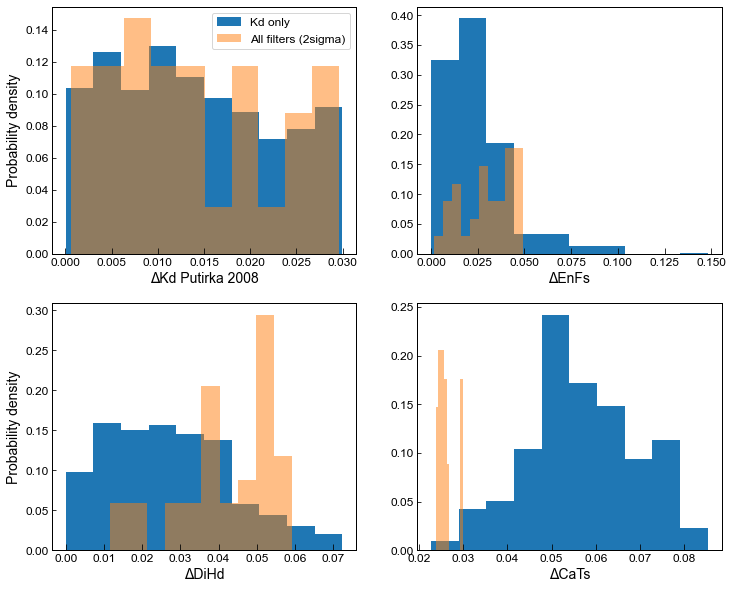

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
# This plots things with probability on the y axis
ax1.hist(MM4_All['Delta_Kd_Put2008'], weights=np.ones_like(MM4_All['Delta_Kd_Put2008']) / len(MM4_All['Delta_Kd_Put2008']), label='Kd only')
ax1.hist(MM1_All['Delta_Kd_Put2008'], weights=np.ones_like(MM1_All['Delta_Kd_Put2008']) / len(MM1_All['Delta_Kd_Put2008']) , label='All filters (2sigma)', alpha=0.5)
ax1.set_xlabel('ΔKd Putirka 2008')
ax1.set_ylabel('Probability density')
ax1.legend()

# This plots things with probability on the y axis
ax2.hist(MM4_All['Delta_EnFs'], weights=np.ones_like(MM4_All['Delta_EnFs']) / len(MM4_All['Delta_EnFs']) )#, label='All filters (2sigma)', color='salmon')
ax2.hist(MM1_All['Delta_EnFs'], weights=np.ones_like(MM1_All['Delta_EnFs']) / len(MM1_All['Delta_EnFs']), alpha=0.5)
ax2.set_xlabel('ΔEnFs')

# This plots things with probability on the y axis
ax3.hist(MM4_All['Delta_DiHd'], weights=np.ones_like(MM4_All['Delta_DiHd']) / len(MM4_All['Delta_DiHd']) )#, label='All filters (2sigma)', color='salmon')
ax3.hist(MM1_All['Delta_DiHd'], weights=np.ones_like(MM1_All['Delta_DiHd']) / len(MM1_All['Delta_DiHd']) , alpha=0.5)
ax3.set_xlabel('ΔDiHd')
ax3.set_ylabel('Probability density')
# This plots things with probability on the y axis
ax4.hist(MM4_All['Delta_CaTs'], weights=np.ones_like(MM4_All['Delta_CaTs']) / len(MM4_All['Delta_CaTs']) )#, label='All filters (2sigma)', color='salmon')
ax4.hist(MM1_All['Delta_CaTs'], weights=np.ones_like(MM1_All['Delta_CaTs']) / len(MM1_All['Delta_CaTs']), alpha=0.5)
ax4.set_xlabel('ΔCaTs')

# Plotting
-as everything is a pandas dataframe, you can just do variablename['Column heading'] to pull out the variable of interest. 
- Here comparing first match, with sigma=1 and sigma=2
- We show average for cpx with a diamond and error bar, as well as all matches as very faint dots


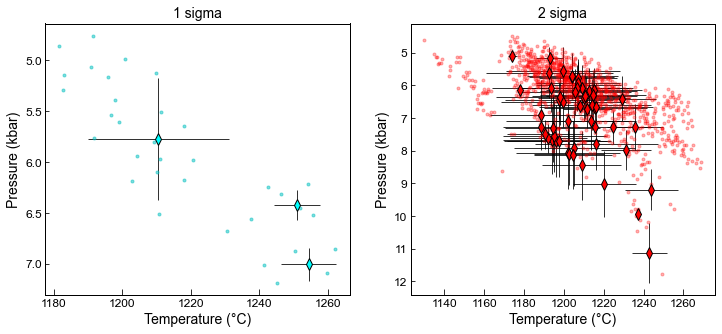

In [18]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5))

# Subplot1
ax1.plot(MM1_All['T_K_calc']-273.15,  MM1_All['P_kbar_calc'], '.c', alpha=0.5)
ax1.errorbar(MM1_Av['Mean_T_K_calc']-273.15,  MM1_Av['Mean_P_kbar_calc'],
             xerr=MM1_Av['st_dev_T_K_calc'], yerr=MM1_Av['st_dev_P_kbar_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=8, mec='k')
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Pressure (kbar)')
ax1.set_title('1 sigma')
# Subplot2
ax2.plot(MM1_2s_All['T_K_calc']-273.15,  MM1_2s_All['P_kbar_calc'], '.r', alpha=0.3)

ax2.errorbar(MM1_2s_Av['Mean_T_K_calc']-273.15,  MM1_2s_Av['Mean_P_kbar_calc'],
             xerr=MM1_2s_Av['st_dev_T_K_calc'], yerr=MM1_2s_Av['st_dev_P_kbar_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='red', ms=8, mec='k')
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Pressure (kbar)')
ax2.set_title('2 sigma')
ax1.invert_yaxis()
ax2.invert_yaxis()


C:\Users\penny\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Pressure (kbar)')

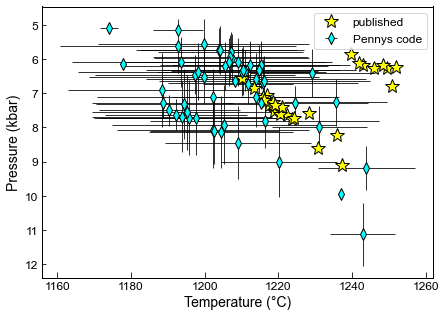

In [24]:
# Compare to published data for Gleeson

Published['Pressure']
Published['Temperature']
fig, (ax1) = plt.subplots(1, figsize=(7, 5))

# Subplot1
ax1.errorbar(MM1_2s_Av['Mean_T_K_calc']-273.15,  MM1_2s_Av['Mean_P_kbar_calc'],
             xerr=MM1_2s_Av['st_dev_T_K_calc'], yerr=MM1_2s_Av['st_dev_P_kbar_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=8, mec='k', label='Pennys code')
ax1.plot(Published['Temperature'], Published['Pressure'], '*k', markerfacecolor='yellow', markersize=15, label='published')
ax1.legend()
ax1.invert_yaxis()
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Pressure (kbar)')